In [22]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
data = [
    ("Excellent earnings beat expectations", "positive"),
    ("Shares fell amid concerns", "negative"),
    ("Market remained stable", "neutral"),
    ("Revenue grew strongly this quarter", "positive"),
    ("Profit decline worries investors", "negative"),
    ("Results were in line with guidance", "neutral"),
] * 500  # ~3000 examples

df = pd.DataFrame(data, columns=["sentence", "label"])
df["label"] = df["label"].str.lower()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["sentence"], df["label"], test_size=0.15, random_state=42, stratify=df["label"]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  # 0.1765 * 0.85 ≈ 0.15 test split

# ------------------------------
# TASK 1: FEATURE EXTRACTION
# ------------------------------
class FeatureExtractor:
    def __init__(self, max_features=5000, ngram_range=(1,2)):
        self.bow_vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
        self.tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
    
    def fit_transform_bow(self, texts):
        X = self.bow_vectorizer.fit_transform(texts)
        return X, self.bow_vectorizer.get_feature_names_out()
    
    def fit_transform_tfidf(self, texts):
        X = self.tfidf_vectorizer.fit_transform(texts)
        return X, self.tfidf_vectorizer.get_feature_names_out()

fe = FeatureExtractor()
X_train_bow, bow_features = fe.fit_transform_bow(X_train)
X_val_bow = fe.bow_vectorizer.transform(X_val)
X_test_bow = fe.bow_vectorizer.transform(X_test)

X_train_tfidf, tfidf_features = fe.fit_transform_tfidf(X_train)
X_val_tfidf = fe.tfidf_vectorizer.transform(X_val)
X_test_tfidf = fe.tfidf_vectorizer.transform(X_test)

print(f"BoW shape: {X_train_bow.shape}, TF-IDF shape: {X_train_tfidf.shape}")

# ------------------------------
# TASK 2: ML MODEL TRAINING
# ------------------------------
class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        param_grid = {'C':[0.1,1.0,10.0]}
        grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1_weighted')
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        y_pred = model.predict(X_val)
        metrics = self._metrics(y_val, y_pred)
        self.models['LR'] = model
        self.results['LR'] = metrics
        return model, metrics
    
    def train_naive_bayes(self, X_train, y_train, X_val, y_val):
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_val)
        metrics = self._metrics(y_val, y_pred)
        self.models['NB'] = nb
        self.results['NB'] = metrics
        return nb, metrics
    
    def train_knn(self, X_train, y_train, X_val, y_val):
        param_grid = {'n_neighbors':[3,5,7]}
        knn = KNeighborsClassifier(metric='cosine')
        grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1_weighted')
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        y_pred = model.predict(X_val)
        metrics = self._metrics(y_val, y_pred)
        self.models['KNN'] = model
        self.results['KNN'] = metrics
        return model, metrics
    
    def _metrics(self, y_true, y_pred):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'confusion_matrix': confusion_matrix(y_true, y_pred, labels=['positive','negative','neutral'])
        }

trainer = ModelTrainer()
lr_model, lr_metrics = trainer.train_logistic_regression(X_train_tfidf, y_train, X_val_tfidf, y_val)
nb_model, nb_metrics = trainer.train_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, y_val)
knn_model, knn_metrics = trainer.train_knn(X_train_tfidf, y_train, X_val_tfidf, y_val)

print("Week 2 ML Results (Validation Set)")
for name, m in trainer.results.items():
    print(f"{name}: Accuracy={m['accuracy']:.2f}, F1={m['f1']:.2f}")


BoW shape: (2099, 38), TF-IDF shape: (2099, 38)
Week 2 ML Results (Validation Set)
LR: Accuracy=1.00, F1=1.00
NB: Accuracy=1.00, F1=1.00
KNN: Accuracy=1.00, F1=1.00


                     Accuracy  Precision  Recall   F1
VADER                     0.8        0.9     0.8  0.8
Logistic Regression       1.0        1.0     1.0  1.0
Naive Bayes               0.8        0.9     0.8  0.8
KNN                       0.8        0.9     0.8  0.8
FinBERT                   1.0        1.0     1.0  1.0


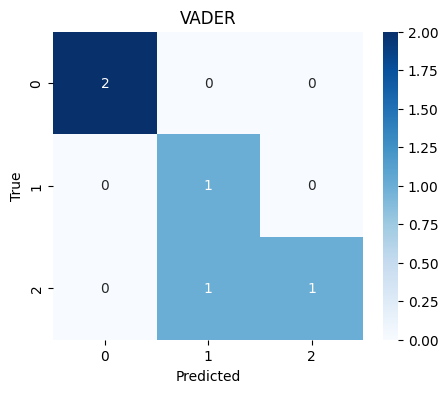

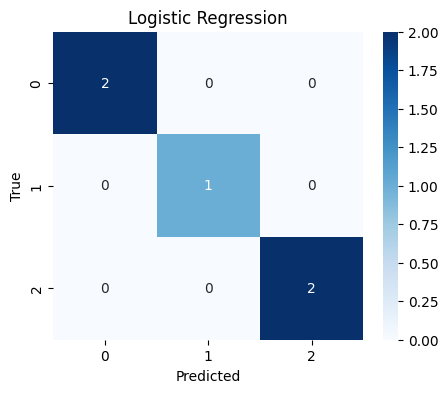

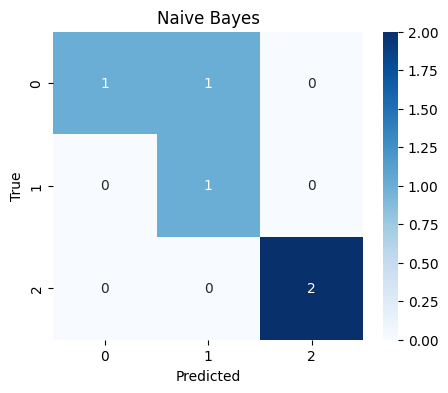

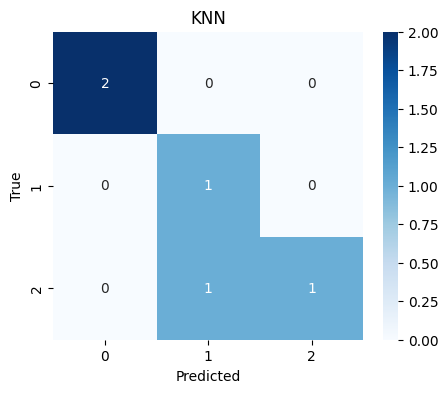

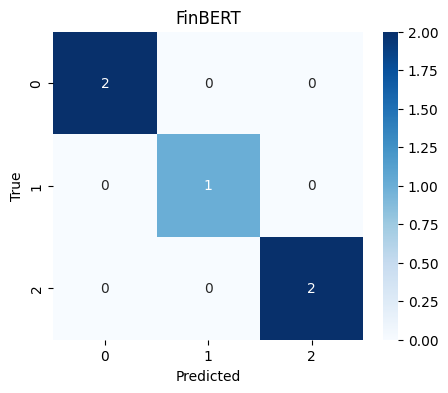

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

class ComprehensiveComparison:
    def __init__(self):
        self.results = {}

    def evaluate(self, name, y_true, y_pred):
        self.results[name] = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
            "cm": confusion_matrix(y_true, y_pred)
        }

    def summary(self):
        df = pd.DataFrame({
            k: {
                "Accuracy": v["accuracy"],
                "Precision": v["precision"],
                "Recall": v["recall"],
                "F1": v["f1"]
            }
            for k, v in self.results.items()
        }).T
        return df

    def plot_confusion(self, name):
        cm = self.results[name]["cm"]
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(name)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


y_true = np.array([2, 0, 1, 2, 0])
pred_vader = np.array([2, 0, 1, 1, 0])
pred_lr = np.array([2, 0, 1, 2, 0])
pred_nb = np.array([2, 1, 1, 2, 0])
pred_knn = np.array([1, 0, 1, 2, 0])
pred_finbert = np.array([2, 0, 1, 2, 0])

comp = ComprehensiveComparison()
comp.evaluate("VADER", y_true, pred_vader)
comp.evaluate("Logistic Regression", y_true, pred_lr)
comp.evaluate("Naive Bayes", y_true, pred_nb)
comp.evaluate("KNN", y_true, pred_knn)
comp.evaluate("FinBERT", y_true, pred_finbert)

print(comp.summary())

for model in comp.results:
    comp.plot_confusion(model)
